# Packages

In [3]:
#Preparation
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()

from selenium import webdriver
from bs4 import BeautifulSoup as bs
import requests
import time

#Model
import statsmodels.api as sm
from scipy.stats import boxcox
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.diagnostic import linear_harvey_collier, normal_ad, het_breuschpagan

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Data cleaning

**What is the dataset?**
- The dataset is consists in IMDB-scrapped data, and was downloaded from [this Kaggle page](https://www.kaggle.com/danielgrijalvas/movies).
- Number of movies: 6,813
- Date range: 1986 - 2017

**What are the main transformations applied during the cleaning process?**

Adjust Budget and Gross:
- Smoothing Budget and Gross amounts with inflation
- Drop Budget and Gross outliers
- Remove rows for which Gross/Budget ratio > 25
- Remove rows that are outside Gross whiskers or Budget whiskers

Assess Director and Star popularity:
- Add Director and Star movie count over the period
- Add Director maximum gross generated over the period
- Add the number of Star nominations over the 5 years preceding the movie (scrapped from Oscars and Golden Globes websites)

Categorize Production companies:
- Tier 1 if they generated the top 20% of market revenue, etc. until Tier 5.

#### 1. Define functions

In [25]:
def clean_dates(df):
    """Function breaking the released column into a the released year and month."""
    
    df['year'] = df.released.str[0:4]
    df['month'] = np.where(df.released.str.len()>=7,df.released.str[5:7],0)
    df.drop(df[df.month==0].index,inplace=True)
    df.drop('released',axis=1,inplace=True)
    df.year = df.year.astype(int)
    df.month = df.month.astype(int)
    df['age'] = df.eval('2017-year')
    return df

def clean_inf_df(inf_df):
    """Function calculating for each year:
    - inflation to the next year (column name: inflation)
    - inflation to 2016 (column name: cum_inflation)"""
    
    inf_df.columns = [col.lower().strip() for col in inf_df.columns]
    inf_df = inf_df[['year','total']][(inf_df.year >= df.year.min())&(inf_df.year <= df.year.max())].reset_index(drop=True).rename(columns={'total':'inflation'})
    inf_df.inflation = 1 + inf_df.inflation/100
    inf_df.loc[inf_df.year==2017,'inflation']=1
    inf_df['cum_inflation'] = inf_df.inflation[::-1].cumprod()
    return inf_df

def drop_budget_gross_outliers(df):
    """Function removing budget and gross outliers, using 2 methologies."""
    
    #Remove rows for which gross/budget > 25
    df = df.drop(df[(df.budget==0)|(df.gross==0)].index).reset_index(drop=True)
    df.drop(df[df.eval('gross/budget')>25].index,inplace=True)
    #Remove rows that are outside of budget and gross whiskers
    for i in ['budget','gross']:
        q1,q3 = np.percentile(df[i], [25,75])
        iqr = q3 - q1
        w1 = q1 - (1.5*iqr)
        w3 = q3 + (1.5*iqr)
        df.drop(df[(df[i]<w1)|(df[i]>w3)].index).reset_index(drop=True)
    return df

def convert_budget_gross(df,inf_df):
    """Function converting budget and gross amounts
    to their 2016 equivalents (taking inflation into account)."""
    
    df = df.merge(inf_df[['year','cum_inflation']],on='year')
    df.budget = (df.budget*df.cum_inflation).astype(int)
    df.gross = (df.gross*df.cum_inflation).astype(int)
    df.drop('cum_inflation',axis=1,inplace=True)
    return df

def clean_restricted_audience(df): 
    rating_dict = {
        'G':0,
        'PG':1,
        'TV-PG':1,
        'B':1,
        'PG-13':1,
        'TV-14':1,
        'B15':1,
        'NC-17':1,
        'TV-MA':1,
        'R':1,
        'NOT RATED':0,
        'UNRATED':0,
        'Not specified':0}
    df['restricted_audience'] = df.rating.map(rating_dict)
    df.drop('rating',axis=1,inplace=True)
    return df

def add_movie_count(df):
    """Function adding a director_movie_count and a star_movie_count column."""
    
    dir_movie_count = pd.DataFrame([df.director.value_counts().index,df.director.value_counts().values],index=['director','director_movie_count']).T
    star_movie_count = pd.DataFrame([df.star.value_counts().index,df.star.value_counts().values],index=['star','star_movie_count']).T
    df = df.merge(dir_movie_count,on='director').merge(star_movie_count,on='star')
    df.director_movie_count = df.director_movie_count.astype(int)
    df.star_movie_count = df.star_movie_count.astype(int)
    return df

def scrape_star_nominations():
    """Function scrapping Oscar and Golden Globes nominees since 1981."""
    
    star_nom = pd.DataFrame()
    
    #Oscar nominees
    for k in range(df.year.min(),df.year.max()+6):
        response = requests.get(f'https://www.oscars.org/oscars/ceremonies/{k}')
        soup = bs(response.content,'lxml')
        stars = [i.text for i in  soup.select('div[class*="actor-name"]')][0:20]
        temp_df = pd.DataFrame(stars,columns=['star'])
        temp_df['year']=k
        temp_df['award']='Oscar'
        star_nom = pd.concat([star_nom,temp_df],ignore_index=True)
        time.sleep(3)
    
    #Golden Globes nominees
    categ_items = ['actress-motion-picture-drama','actor-motion-picture-drama',
     'actress-motion-picture-musical-or-comedy','actor-motion-picture-musical-or-comedy',
     'actress-supporting-role-any-motion-picture','actor-supporting-role-any-motion-picture']

    for categ in categ_items:
        stars = []
        for k in range(9):
            response = requests.get(f'https://www.goldenglobes.com/winners-nominees/best-performance-{categ}?page={k}')
            soup = bs(response.content,'lxml')
            temp_stars = [i.text for i in soup.select('div[class*=field-nominee-title] a[href*=person]')]
            stars = stars + temp_stars
            time.sleep(3)
        stars = stars[15:15+(df.year.max()-df.year.min()+6)*5]
        years = np.repeat(range(df.year.min(),df.year.max()+6),5)[::-1]
        temp_df = pd.DataFrame([stars,years],index=['star','year']).T
        temp_df['award']='Golden Globes'
        star_nom = pd.concat([star_nom,temp_df],ignore_index=True)
        
    star_nom.to_csv('star-nominations.csv',index=False)
    return star_nom
    
def add_star_nominations(star_nom):
    """Function adding a star_nominations column specifying the number
    of nominations received by the star over the 5 years preceeding the release."""
    
    star_nom = star_nom.groupby(['star','year']).agg('count').reset_index()
    df['star_nominations'] = df.apply(lambda x: star_nom[(star_nom.star==x.star)&(star_nom.year<x.year)&(star_nom.year>=x.year-5)].award.sum(),axis=1)
    return df

def add_dir_max_gross(df):
    """Function adding a director_max_gross column specifying the maximum revenue generated by a director."""
    
    dir_gross = df[['director','gross']]
    dir_gross = dir_gross.groupby('director').agg(max).sort_values('gross',ascending=False).rename(columns={'gross':'director_max_gross'}).reset_index()
    return df.merge(dir_gross,on='director')

def add_company_categ(df):
    """Function adding a company_categ column:
    tier_1 if the company is amid the companies that generated
    the top 20% of revenue over the period, and so on."""
    
    company_df = df[['company','gross']].groupby('company').agg('max').sort_values('gross',ascending=False).reset_index()
    company_df['cum_gross'] = company_df.gross.cumsum()
    company_df.cum_gross = (company_df.cum_gross/company_df.gross.sum())*100
    company_df['company_categ'] = pd.cut(company_df.cum_gross,5,labels=['tier_1','tier_2','tier_3','tier_4','tier_5'])
    return df.merge(company_df[['company','company_categ']],on='company')

#### 2. Run the pipeline

In [26]:
df = pd.read_csv('data/imdb-data.csv',encoding = 'latin1')
inf_df = pd.read_csv('data/us-inflation-data.csv')

df = clean_dates(df)
inf_df = clean_inf_df(inf_df)
df = drop_budget_gross_outliers(df)
df = convert_budget_gross(df,inf_df)
df = clean_restricted_audience(df)
df = add_movie_count(df)
df = add_dir_max_gross(df)
df = add_company_categ(df)
#star_nom = get_star_nom()
star_nom = pd.read_csv('data/star-nominations-data.csv')
df = add_star_nominations(star_nom)
df = pd.get_dummies(data=df,columns=['genre','company_categ','month'],drop_first=True)
df.drop(['name','director','writer','star','company','country','runtime','score','votes','year'],axis=1,inplace=True)

# Modelling using Linear Regression

**Variables initially *involved* in the model:**

As an input variable X:
- Budget
- Director Movie Count
- Star Movie Count
- Director Max Gross
- Star Nominations
- Genre (dummies)
- Restricted Audience (dummies)
- Company Category (dummies)
- Release Month (dummies)
- Release Year (dummies)

As a target variable y:
- Gross (normalized via scipy.stats.boxcox)

**Variables initially *removed* from the model:**

- Movie Title
- Director Name
- Writer Name
- Star Name
- Company Name
- Country
- Runtime
- IMDB Score
- IMDB Votes

#### 1. Define functions

In [27]:
def get_y_X(df,dropped_params):
    y = boxcox(df['gross'])[0]
    X = df.drop(dropped_params,axis=1)
    X = sm.add_constant(X)
    return y,X

def check_multicollinearity(df,dropped_params):
    print('***CHECK 1: Multicollinearity***')
    
    X = get_y_X(df,dropped_params)[1]
    col_X = X.drop('const',axis=1)
    VIF_results = pd.Series([VIF(col_X.values,i) for i in range(col_X.shape[1])],index=col_X.columns)

    while sum(VIF_results>10)>0:
        param_VIF_uncompliant = VIF_results[(VIF_results>10)&(VIF_results==VIF_results.max())].index[0]
        dropped_params.append(param_VIF_uncompliant)
        print(f'Dropped parameter: {param_VIF_uncompliant} (VIF: {round(VIF_results.max(),2)})')
        #Generate VIF results for next loop
        X = get_y_X(df,dropped_params)[1]
        col_X = X.drop('const',axis=1)
        VIF_results = pd.Series([VIF(col_X.values,i) for i in range(col_X.shape[1])],index=col_X.columns)

    y,X = get_y_X(df,dropped_params)
    model = sm.OLS(y,X)
    print(f'R-Squared: {round(model.fit().rsquared*100,2)}%')
    print(f'AIC: {round(model.fit().aic,2)}')
    return dropped_params

def check_pvalues(df,dropped_params):
    print('\n***CHECK 2: p-values***')
    
    y,X = get_y_X(df,dropped_params)
    model = sm.OLS(y,X)
    model_pvalues = model.fit().pvalues

    while sum(model_pvalues>0.05)>0:
        param_pvalue_uncompliant = model_pvalues[(model_pvalues>0.05)&(model_pvalues==model_pvalues.max())].index[0]
        dropped_params.append(param_pvalue_uncompliant)
        print(f'Dropped parameter: {param_pvalue_uncompliant} (p-value: {round(model_pvalues.max()*100,2)}%)')
        #Generate X and model for next loop
        y,X = get_y_X(df,dropped_params)
        model = sm.OLS(y,X)
        model_pvalues = model.fit().pvalues
    
    print(f'R-Squared: {round(model.fit().rsquared*100,2)}%')
    print(f'AIC: {round(model.fit().aic,2)}\n')
    return dropped_params

def print_model_summary(df,dropped_params):
    y,X = get_y_X(df,dropped_params)
    model = sm.OLS(y,X)
    print(model.fit().summary())
    
def check_linearity(df,dropped_params):    
    print('\n***CHECK 3: Linearity (Harvey Collier Test)***')
    
    y,X = get_y_X(df,dropped_params)
    model_fit = sm.OLS(y,X).fit()
    try:
        pvalue = linear_harvey_collier(model_fit)[3]
    except:
        print("p-value can't be calculated: the model is not linear.")
    else:
        if pvalue>0.05:
            print(f"p-value = {pvalue*100}% : the model is linear.")
        else:
            print(f"p-value = {pvalue*100}% : the model is not linear.")

def plot_linearity(df,dropped_params):
    y,X = get_y_X(df,dropped_params)
    model = sm.OLS(y,X)
    y_pred = model.predict(model.fit().params)
    pred_df = pd.DataFrame([y,y_pred],index=['actual','prediction']).T

    fig,ax=plt.subplots(1,1,figsize=(15,15))
    sns.regplot(x='actual',y='prediction',data=pred_df,ax=ax)
    ax.set_title('Predicted vs. Actual Movie Revenue',size=20)
    ax.set_xlabel('Actual Revenue',size=15)
    ax.set_ylabel('Predicted Revenue',size=15)
    ax.set_xlim(0,600)
    ax.set_ylim(0,600)

    fig.savefig('linearity-plot.png')

def check_residuals_normality(df,dropped_params):
    print('\n***CHECK 4: Normality of Residuals***')
    
    y,X = get_y_X(df,dropped_params)
    model = sm.OLS(y,X)
    model_fit = model.fit()
    pvalue = normal_ad(model_fit.resid)[1]
    if pvalue>0.05:
        print(f"p-value = {round(pvalue*100,2)}% : residuals are normally distributed.")
    else:
        print(f"p-value = {round(pvalue*100,2)}% : residuals are not normally distributed.")

def plot_residuals_normality(df,dropped_params):
    y,X = get_y_X(df,dropped_params)
    model = sm.OLS(y,X)
    model_fit = model.fit()

    fig,ax=plt.subplots(1,1,figsize=(15,15))
    ax = sns.distplot(model_fit.resid)
    ax.set_title('Distribution of Residuals',size=20)
    fig.savefig('normality-residuals-plot.png')

def check_residuals_variance(df,dropped_params):
    print('\n***CHECK 5: Variance of Residuals***')

    y,X = get_y_X(df,dropped_params)
    model = sm.OLS(y,X)
    model_fit = model.fit()
    pvalue = het_breuschpagan(model_fit.resid,X)[3]
    if pvalue>0.05:
        print(f"p-value = {round(pvalue*100,2)}% : there is a low variance (homoscedasticity).")
    else:
        print(f"p-value = {round(pvalue*100,2)}% : there is a high variance (heteroscedasticity).")
        
def plot_residuals_variance(df,dropped_params):
    y,X = get_y_X(df,dropped_params)
    model = sm.OLS(y,X)
    model_fit = model.fit()
    fig,ax=plt.subplots(1,1,figsize=(15,15))
    ax = model_fit.resid.plot()
    ax.set_title('Variance of Residuals',size=20) 
    ax.set_ylim(-400,400)
    fig.savefig('variance-residuals-plot.png')

#### 2. Run the pipeline

In [28]:
dropped_params = ['gross']
dropped_params = check_multicollinearity(df,dropped_params)
dropped_params = check_pvalues(df,dropped_params)
print_model_summary(df,dropped_params)
check_linearity(df,dropped_params)
check_residuals_normality(df,dropped_params)
check_residuals_variance(df,dropped_params)

***CHECK 1: Multicollinearity***
Dropped parameter: restricted_audience (VIF: 14.81)
R-Squared: 59.32%
AIC: 50871.1

***CHECK 2: p-values***
Dropped parameter: month_8 (p-value: 94.7%)
Dropped parameter: genre_Mystery (p-value: 78.32%)
Dropped parameter: genre_Biography (p-value: 77.12%)
Dropped parameter: genre_Romance (p-value: 63.84%)
Dropped parameter: month_7 (p-value: 55.92%)
Dropped parameter: month_12 (p-value: 46.88%)
Dropped parameter: genre_Sci-Fi (p-value: 40.91%)
Dropped parameter: star_nominations (p-value: 41.48%)
Dropped parameter: month_6 (p-value: 34.07%)
Dropped parameter: genre_Fantasy (p-value: 31.15%)
Dropped parameter: genre_Family (p-value: 31.04%)
Dropped parameter: genre_Western (p-value: 24.98%)
Dropped parameter: month_2 (p-value: 14.42%)
Dropped parameter: genre_Comedy (p-value: 13.43%)
Dropped parameter: genre_Adventure (p-value: 11.15%)
Dropped parameter: month_3 (p-value: 5.7%)
Dropped parameter: genre_Thriller (p-value: 5.31%)
R-Squared: 59.13%
AIC: 508

#### 3. Plot model results

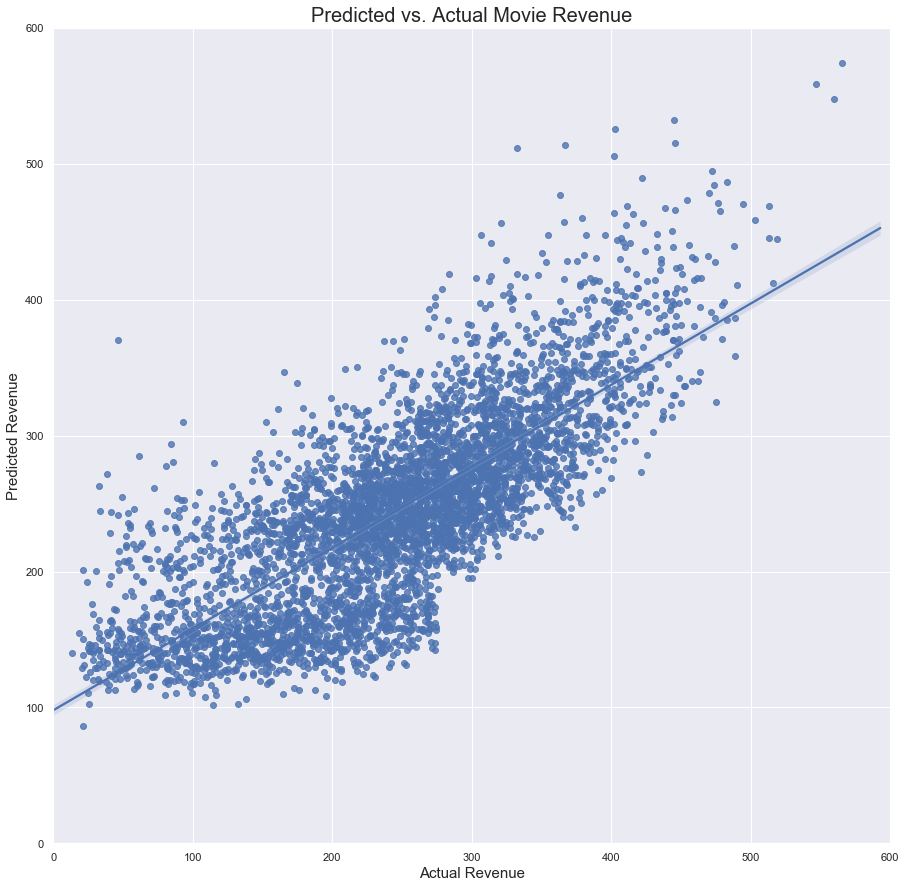

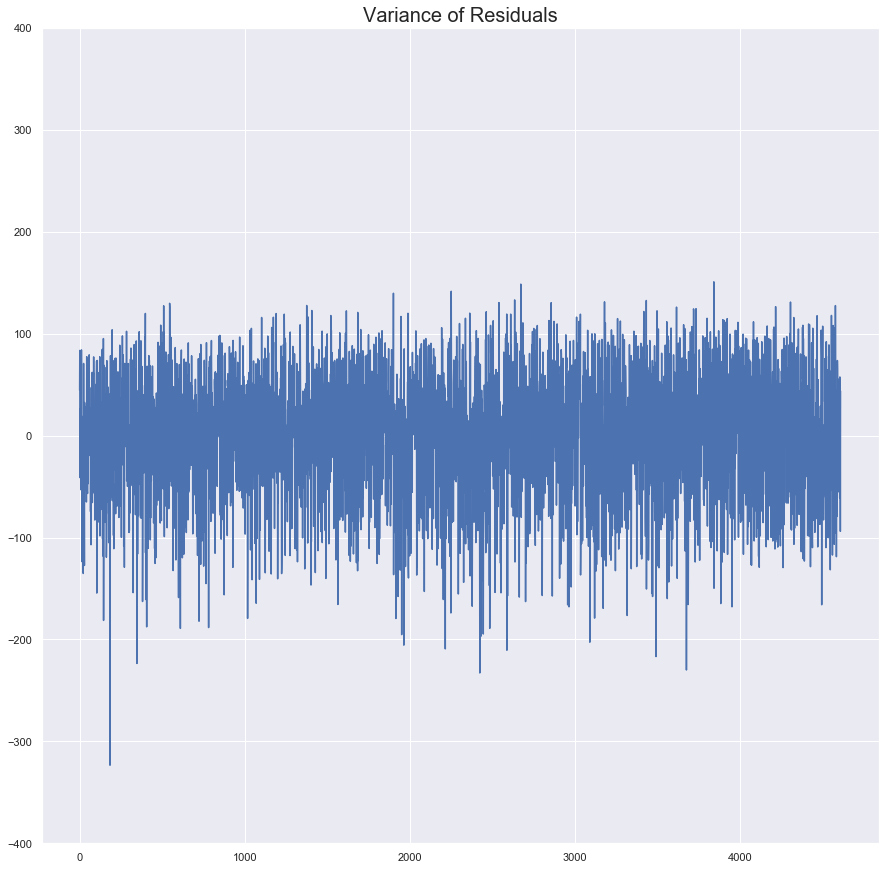

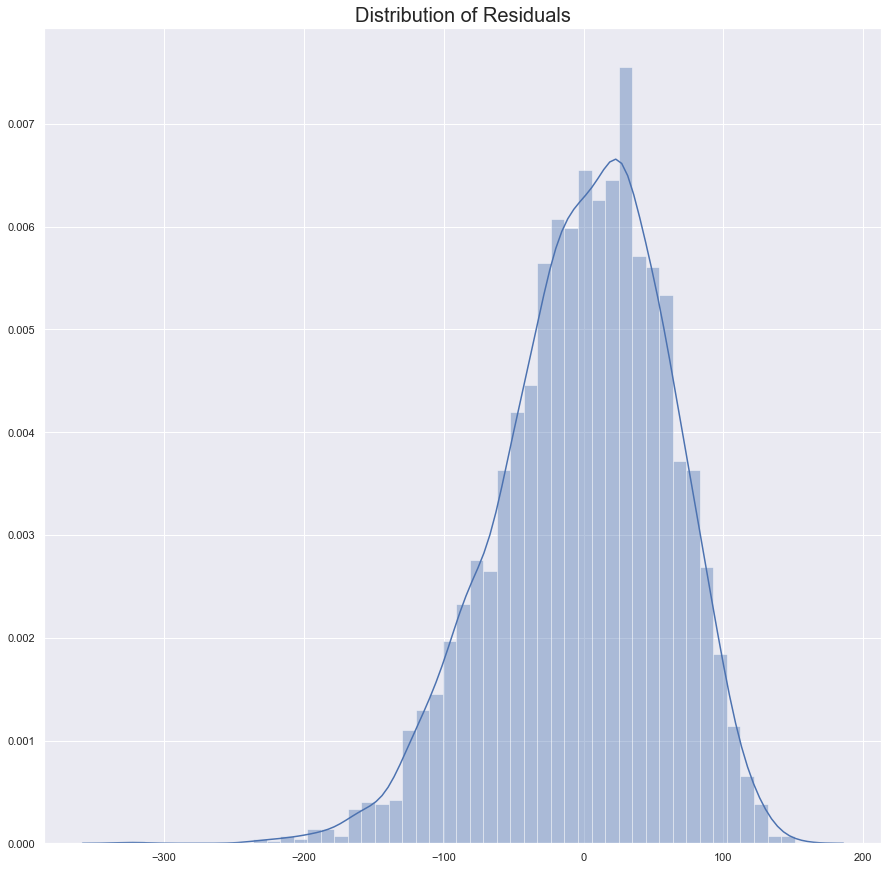

In [31]:
plot_linearity(df,dropped_params)
plot_residuals_variance(df,dropped_params)
plot_residuals_normality(df,dropped_params)

#### 4. Conclusion

**The results of the modelling phase are not satisfying**: predicting movie revenues seems to be a bit more complex than applying a linear regression model.

- After the **multicolinearity check**, R-Squared and AIC performance worsened.
- After the **p-values check**, AIC slighly improved while R-Squared performance decreased again.
- The model didn't pass **OLS assumptions tests**:
    - The **Harvey Collier test** shows that the model is not linear.
    - The **Anderson Darling Test** shows that residuals are not normally distributed.
    - The **Het Breusch Pagan Test** shows that there is a high variance in residuals (heteroskedasticity).

# Scrape stars followers with Selenium (not used in the end)

In [182]:
def scrape_star_followers():
    """Function scrapping a star followers from SocialBakers.com."""
    
    driver = webdriver.Chrome('/Users/gabrielleberanger/Downloads/chromedriver')
    driver.get('https://www.socialbakers.com/statistics/facebook/pages/total/united-states/celebrities/actor')
    time.sleep(2)
    driver.find_element_by_css_selector('tr.replace-with-show-more a').click()
    time.sleep(2)
    driver.find_element_by_name('FullName').send_keys('Jenna Caldwell')
    time.sleep(2)
    driver.find_element_by_name('Email').send_keys('jenna.victoria.caldwell@gmail.com')
    time.sleep(2)
    driver.find_element_by_name('Company').send_keys('Cloudera')
    time.sleep(2)
    driver.find_element_by_name('submitMktoForm').click()
    time.sleep(10)

    star_fol = pd.DataFrame()
    for k in range(50):
        star = [i.text for i in driver.find_elements_by_css_selector('span.show-name')]
        star_followers = [int(('').join(i.text.strip('Total Fans\n').split(' '))) for i in driver.find_elements_by_css_selector('td.name+td>div.item')]
        temp_df = pd.DataFrame([star,star_followers],index=['star','star_followers']).T
        star_fol = pd.concat([star_fol,temp_df],ignore_index=True)
        driver.find_element_by_css_selector('tr.replace-with-show-more a').click()
        time.sleep(10)
    star_fol = star_fol.drop_duplicates().reset_index(drop=True)
    star_fol.to_csv('data/star-followers.csv',index=False)
    return star_fol